# Estimating MI by noise contrastive method (InfoNCE)

## Setup

The following cell imports the necessary packages:

In [1]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

Set random seed for reproducibility.

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

Specify the hyper-parameters:

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--hidden_layer", type=int, default=6, help="the number of hidden layers")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--exc", type=int, default=1, help="whether exclude the data sample from the reference samples")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [4]:
continue_train = True  # set to True to continue to train
load_available = True # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [5]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

## Model

In [6]:
name = f'./results/InfoNCE_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [12]:
def infonce_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1.logsumexp(dim = 1).mean() - np.log(sample_size)
    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
        writer.add_scalar('log ratio', a-b-np.log(sample_size), epoch)
    return lower_bound

In [13]:
def infonce_exc_loss(net, x_samples, y_samples, writer=None, epoch=None, reg=False):
    sample_size = x_samples.shape[0]
    x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
    y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))
    mask =  torch.ones([sample_size]).diag().unsqueeze(-1).bool().cuda()
    T0 = net(torch.cat([x_samples,y_samples], dim = -1))
    T1 = net(torch.cat([x_tile, y_tile], dim = -1))
    a = T0.mean()
    b = T1[~mask].reshape(-1, sample_size-1, 1).logsumexp(dim = 0).mean() - np.log(sample_size-1)

    if reg:
        lower_bound = a - b - b**2
    else:
        lower_bound = a - b

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)
    return lower_bound

Load previous results.

In [9]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

## Training

Since maximizing the infoNCE bound over $f$ attains the mutual information

\begin{align}
I(X\wedge Y) = \sup_{f} I_{\text{infoNCE}}(f),
\end{align}

we train the neural network to minimize the loss $-I_{\text{infoNCE}}(f)$. The optimal solution $f$ satisfies

\begin{align}
f(x,y)=\log \frac{p_{Y|X}(y|x)}{p_{Y}(y)} + c \quad \forall x\in \mathcal{X}, y \in \mathcal{Y}
\end{align}

for any constant $c$.

The following cell train the neural network using the data samples.

In [11]:
continue_train = True  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_loss(discriminator, train_x, train_y, reg=True) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_loss(discriminator, X, Y, writer, i)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, d= opt.d if opt.d<6 else 6 )
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, i)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, i)


# writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 0, loss: 0.000000, mi_est: 0.000000
Iternation: 1000, loss: -3.142045, mi_est: 4.086989
Iternation: 2000, loss: -3.438602, mi_est: 4.582865
Iternation: 3000, loss: -2.926898, mi_est: 4.315511
Iternation: 4000, loss: -3.022312, mi_est: 4.620934
Iternation: 5000, loss: -3.567674, mi_est: 4.948432
Iternation: 6000, loss: -3.253861, mi_est: 4.973514
Iternation: 7000, loss: -1.766921, mi_est: 4.626692
Iternation: 8000, loss: -3.308816, mi_est: 4.722925
Iternation: 9000, loss: -3.455814, mi_est: 4.935301


In [12]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


## MI estimates

Use moving average to smooth the estimated MI in each training iteration.

In [13]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

Plot the MI estimation curve against the training iteration, together with the ground truth.

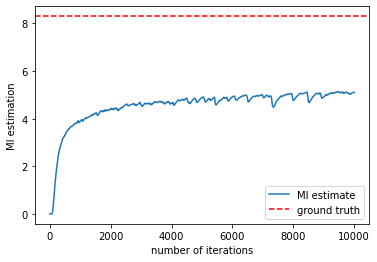

In [14]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()

## InfoNCE w\o datasamples

In [6]:
name = f'./results/InfoNCE_exc_dim{opt.d}_reg{opt.reg}'   # filename
chkpt_name = name+'.pt'      # checkpoint
opt.reg = 1
from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/InfoNCE_exc_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')
discriminator2 = Net(input_size=opt.d*2, hidden_layers=opt.hidden_layer, hidden_size=opt.hidden_dim)

# move NN model to GPU if GPU is available
if cuda:
    discriminator2.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator2.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [7]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator2.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


In [31]:
continue_train = True  # set to True to continue to train
if continue_train:
    for i in range(opt.n_epoch*opt.n_iters_1epoch):
        data_joint = resample(XY, batch_size=opt.batch_size)
        train_x = data_joint[:,0:opt.d]
        train_y = data_joint[:,opt.d:]

        optimizer_D.zero_grad()
        loss = -infonce_exc_loss(discriminator2, train_x, train_y, reg=opt.reg) # negative infonce_bound as the loss
        loss.backward()

        optimizer_D.step()
        with torch.no_grad():
            mi_est = infonce_loss(discriminator2, X, Y, writer, i)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)

        if i%1000==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
            fig = plot_fig(discriminator2, X, Y, d=opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, i)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, i)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, i)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, i)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, i)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, i)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, i)

# writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 0, loss: 0.025959, mi_est: 0.000000
Iternation: 1000, loss: -4.406321, mi_est: 4.253283
Iternation: 2000, loss: -4.051922, mi_est: 3.840552
Iternation: 3000, loss: -9.367400, mi_est: 4.951554
Iternation: 4000, loss: -2.406297, mi_est: 3.978122
Iternation: 5000, loss: -2.155282, mi_est: 3.694847
Iternation: 6000, loss: -9.591160, mi_est: 3.849643
Iternation: 7000, loss: -1.218609, mi_est: 0.212527
Iternation: 8000, loss: -0.255599, mi_est: 0.115849
Iternation: 9000, loss: 0.182922, mi_est: -0.055142


In [32]:
mi_copy2 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy2[k] = (1-ma_rate) * mi_copy2[k-1] + ma_rate * mi_copy2[k]

In [21]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator2.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


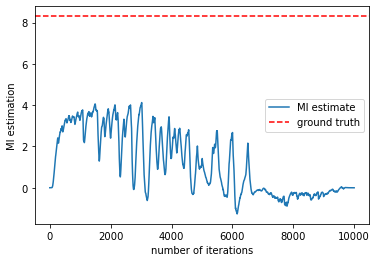

In [33]:
plt.plot(mi_copy2, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()

## InfoNCE with GT reference distribution

In [108]:
discriminator3 = Net(input_size=opt.d*2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator3.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator3.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [109]:
name = f'./results/InfoNCE_knownref_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint
writer = SummaryWriter(f'./results/log/InfoNCE_knownref_dim{opt.d}')


# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator3.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

Previous results loaded.


In [110]:
def estimate_withGT(Net, jointdata, marginaldata):
    L = Net(jointdata).mean()
    L_ = discriminator3(marginaldata).reshape((jointdata.shape[0], jointdata.shape[0], -1)).logsumexp(1) - np.log(jointdata.shape[0])
    return L - L_.mean()

In [111]:
idx = torch.randperm(opt.sample_size)
data = GaussianData(opt.sample_size**2, d=opt.d, rho=opt.rho)
data2 = GaussianData(opt.sample_size*opt.batch_size, d=opt.d, rho=opt.rho)
ref_Y = data.Y
ref_X = X.repeat(opt.sample_size, 1)
ref_data = torch.cat((ref_X, ref_Y), dim=1)

# continue_train = True  # set to True to continue to train
_iter = 0
if continue_train:
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)

        for j in range(opt.n_iters_1epoch):
            optimizer_D.zero_grad()
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]

            batch_X_ref = X[batch_idx.unsqueeze(0).repeat(
                opt.sample_size, 1)]
            batch_Y_ref = data2.Y
            batch_Y_ref = batch_Y_ref.reshape((-1,) + batch_X_ref.shape[1:])
            # define the loss
            L = -discriminator3(torch.cat((batch_X, batch_Y),dim=1)).mean()
            L_ = discriminator3(torch.cat((batch_X_ref, batch_Y_ref), dim=-1)).reshape(
                    (opt.sample_size, batch_idx.shape[0],
                        -1)).logsumexp(1) - np.log(batch_Y_ref.shape[0])
            loss = L + L_.mean()
            loss.backward()

            optimizer_D.step()
            writer.add_scalar("Loss/train",
                                    loss.item(),
                                    global_step=_iter)
            writer.add_scalar("L", L.item(), global_step=_iter)
            writer.add_scalar("L_.mean()",
                                    L_.mean().item(),
                                    global_step=_iter)
            _iter += 1

            with torch.no_grad():
                mi_est = estimate_withGT(discriminator3, XY, ref_data)

            mi_list.append(mi_est.item())
            writer.add_scalar('mi_list', mi_est, _iter)
            writer.add_scalar('loss', loss, _iter)
            if _iter%500==0:
                print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))

writer.add_graph(discriminator3, (XY,))

In [112]:
overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator3.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [113]:
mi_copy3 = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy3[k] = (1-ma_rate) * mi_copy3[k-1] + ma_rate * mi_copy3[k]

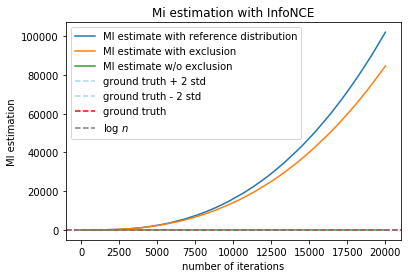

In [114]:
std = 0.183
plt.plot(mi_copy3, label='MI estimate with reference distribution')
plt.plot(mi_copy2, label='MI estimate with exclusion')
plt.plot(mi_copy, label='MI estimate w/o exclusion')

plt.axhline(Ground_truth+2*std,label='ground truth + 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth-2*std,label='ground truth - 2 std',linestyle='--',color='lightblue')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')

plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('Mi estimation with InfoNCE')
plt.legend()
# plt.savefig(f'results/InfoNCE_wo_datapoints_dim{opt.d}_ma{ma_rate}.pdf')